In [4]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Path ke 
sdir = 'MangoLeafBD Dataset'

filepaths = []
labels = []
classlist = os.listdir(sdir)

for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df.head())
print(df['labels'].value_counts())

                                           filepaths       labels
0  MangoLeafBD Dataset\Anthracnose\20211008_12424...  Anthracnose
1  MangoLeafBD Dataset\Anthracnose\20211008_12425...  Anthracnose
2  MangoLeafBD Dataset\Anthracnose\20211008_12425...  Anthracnose
3  MangoLeafBD Dataset\Anthracnose\20211008_12425...  Anthracnose
4  MangoLeafBD Dataset\Anthracnose\20211008_12425...  Anthracnose
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: labels, dtype: int64


In [6]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [7]:
data_dir = 'MangoLeafBD Dataset'
df = loading_the_data(data_dir)

df

,filepaths,labels
0,MangoLeafBD Dataset\Anthracnose\20211008_12424...,Anthracnose
1,MangoLeafBD Dataset\Anthracnose\20211008_12425...,Anthracnose
2,MangoLeafBD Dataset\Anthracnose\20211008_12425...,Anthracnose
3,MangoLeafBD Dataset\Anthracnose\20211008_12425...,Anthracnose
4,MangoLeafBD Dataset\Anthracnose\20211008_12425...,Anthracnose
...,...,...
3995,MangoLeafBD Dataset\Sooty Mould\IMG_20211212_1...,Sooty Mould
3996,MangoLeafBD Dataset\Sooty Mould\IMG_20211212_1...,Sooty Mould
3997,MangoLeafBD Dataset\Sooty Mould\IMG_20211212_1...,Sooty Mould
3998,MangoLeafBD Dataset\Sooty Mould\IMG_20211212_1...,Sooty Mould


In [6]:
data_balance = df.labels.value_counts()
data_balance

labels
Powdery Mildew      500
Cutting Weevil      500
Anthracnose         500
Bacterial Canker    500
Sooty Mould         500
Gall Midge          500
Healthy             500
Die Back            500
Name: count, dtype: int64

In [7]:
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

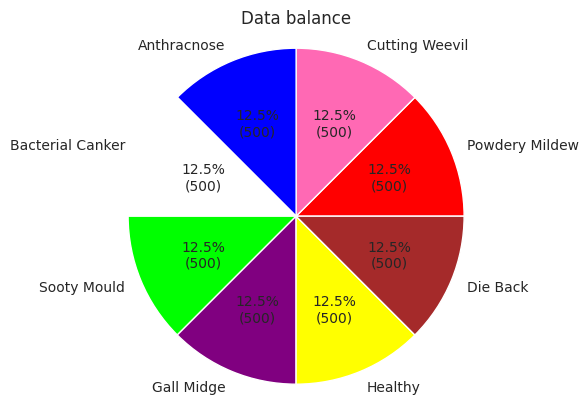

In [8]:
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#FF0000", "#FF69B4", "#0000FF", "#FFFFFF", "#00FF00", "#800080", "#FFFF00", "#A52A2A", "#40E0D0", "#FFA500"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

In [9]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [10]:
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [11]:
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred

In [12]:
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45, fontsize=8)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

In [13]:
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block

In [14]:
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [15]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [16]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


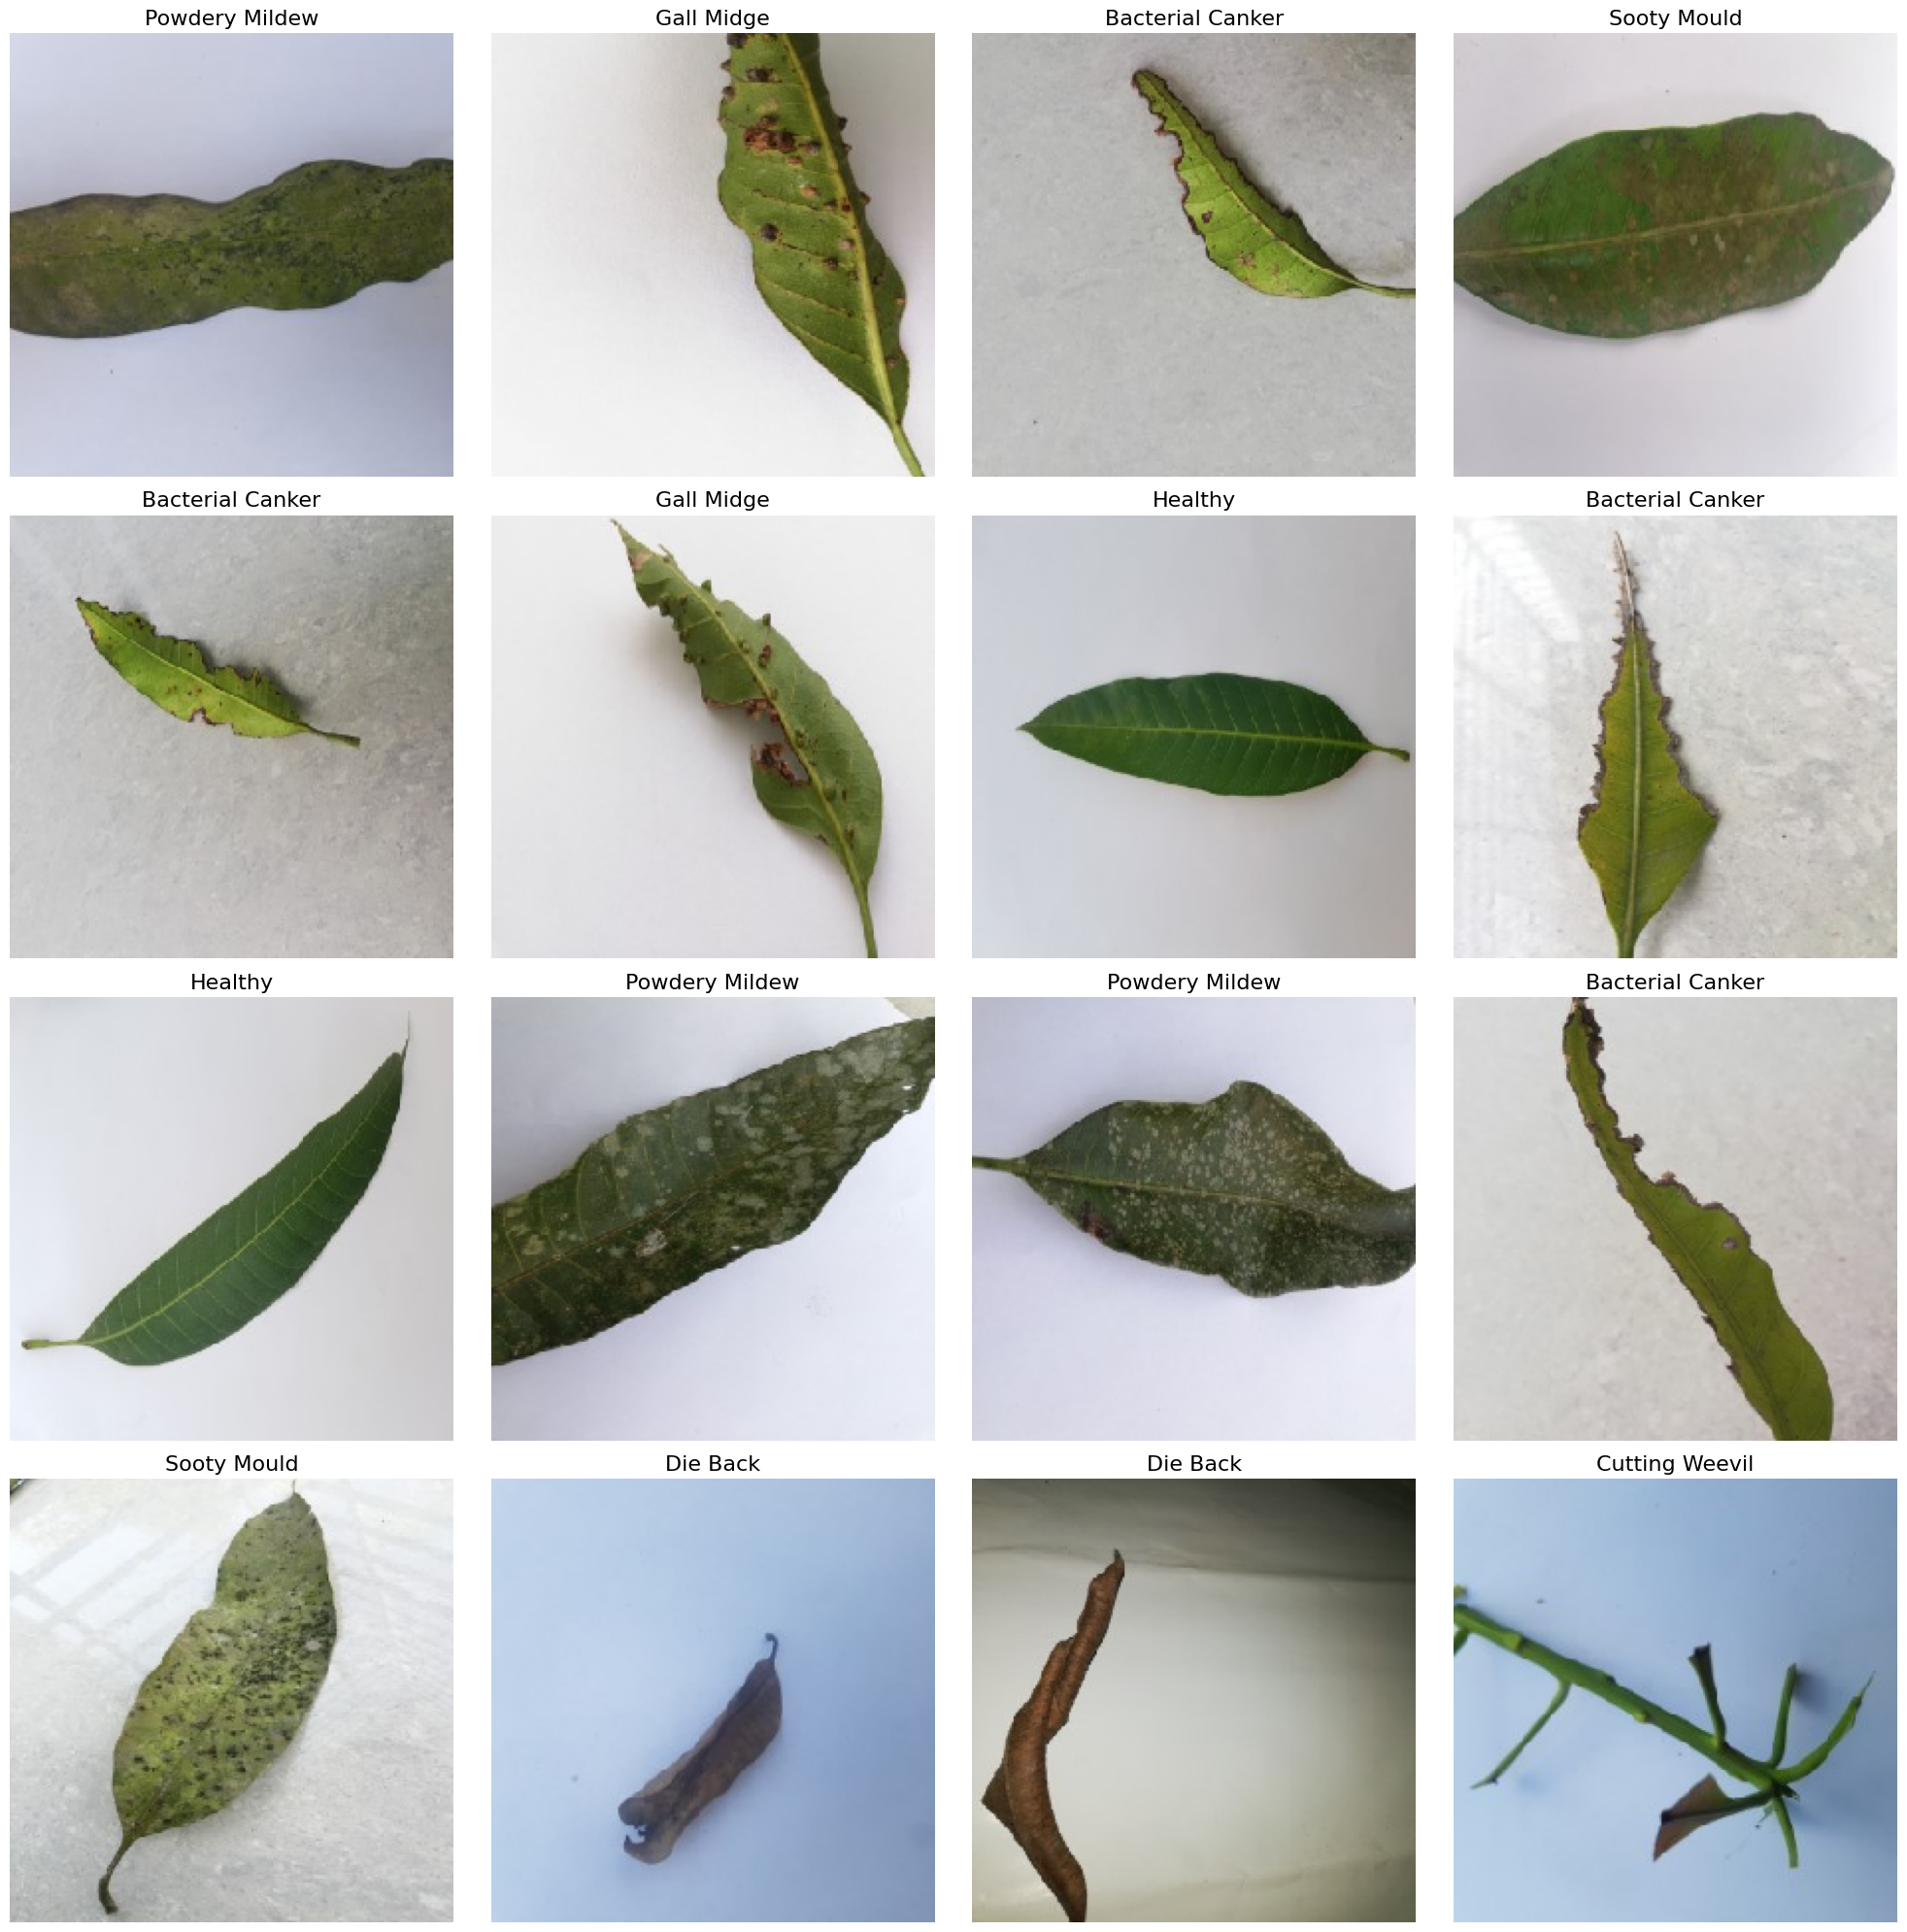

In [17]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))

In [19]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation


EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
for layer in EfficientNetB3_model.layers:
    print(layer.name, layer.trainable)

input_layer True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block1b_dwconv True
block1b_bn True
block1b_activation True
block1b_se_squeeze True
block1b_se_reshape True
block1b_se_reduce True
block1b_se_expand True
block1b_se_excite True
block1b_project_conv True
block1b_project_bn True
block1b_drop True
block1b_add True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn Tr

In [21]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,991,447 (41.93 MB)

 Trainable params: 10,900,752 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [22]:
epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs=epochs, verbose=1,
                                                  validation_data=valid_gen, shuffle=False,
                                                  callbacks=[early_stopping])

Epoch 1/20


I0000 00:00:1718888689.797232     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718888689.968405     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2846 - loss: 2.2221

W0000 00:00:1718888727.041431     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 206s 201ms/step - accuracy: 0.2851 - loss: 2.2199 - val_accuracy: 0.0625 - val_loss: 2.2294
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - accuracy: 0.6297 - loss: 1.0897 - val_accuracy: 0.2500 - val_loss: 2.0610
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.7609 - loss: 0.7828 - val_accuracy: 0.6800 - val_loss: 1.1345
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.8248 - loss: 0.6094 - val_accuracy: 0.9350 - val_loss: 0.4336
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.8512 - loss: 0.5147 - val_accuracy: 0.9750 - val_loss: 0.2263
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.8876 - loss: 0.4404 - val_accuracy: 0.9875 - val_loss: 0.1781
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 148ms/step - accuracy: 0.9142 - loss: 0.3703 - val_accuracy: 0.9950 - val_loss: 0.1491
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.9348 - loss: 0.3091 - va

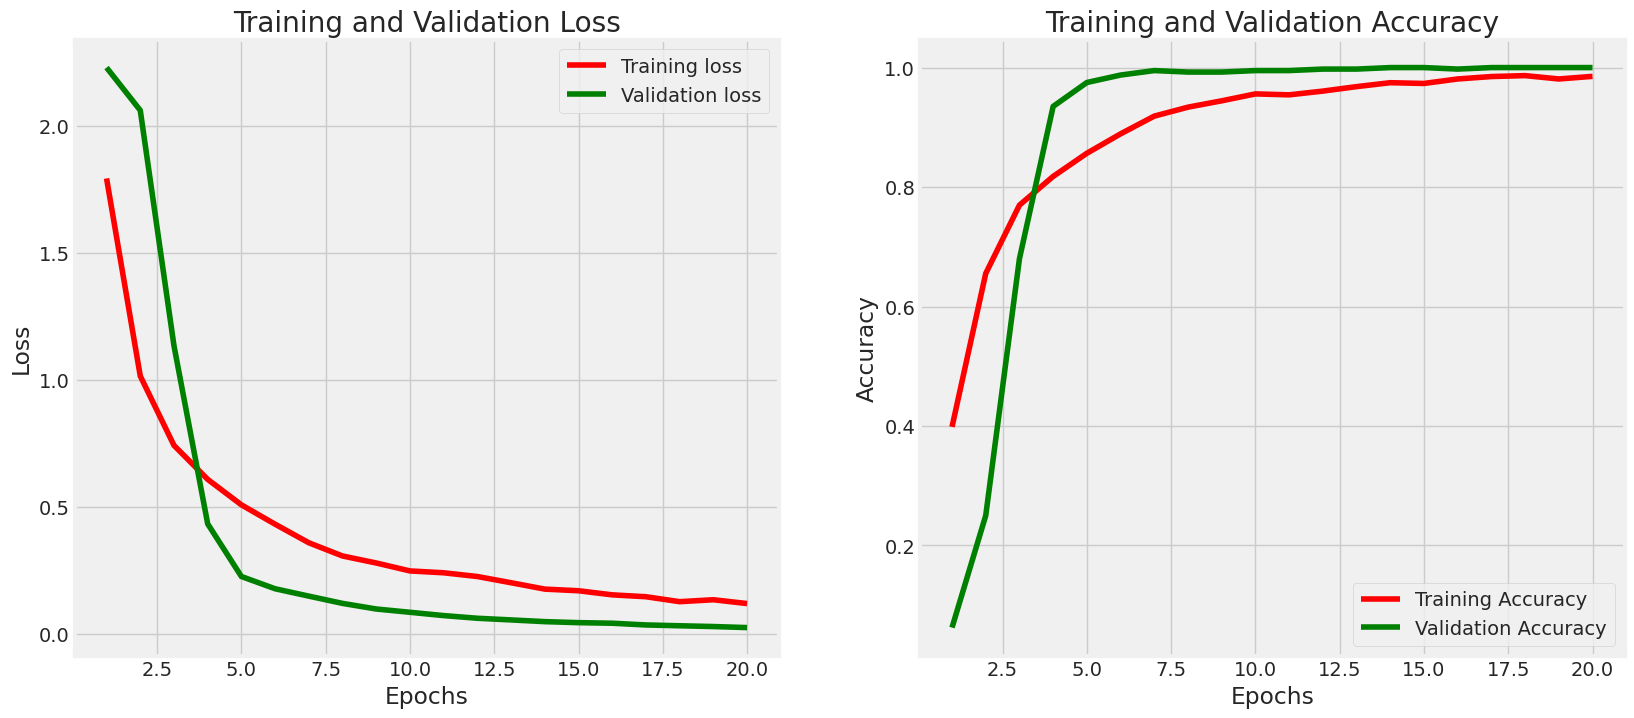

In [23]:
model_performance(EfficientNetB3_history, epochs)

In [24]:
model_evaluation(EfficientNetB3_model)

200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 1.0000 - loss: 0.0189
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 0.0244
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0228
Train Loss:  0.018794799223542213
Train Accuracy:  1.0
--------------------
Validation Loss:  0.02530526928603649
Validation Accuracy:  1.0
--------------------
Test Loss:  0.023125577718019485
Test Accuracy:  1.0


 5/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

W0000 00:00:1718889306.432219     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step


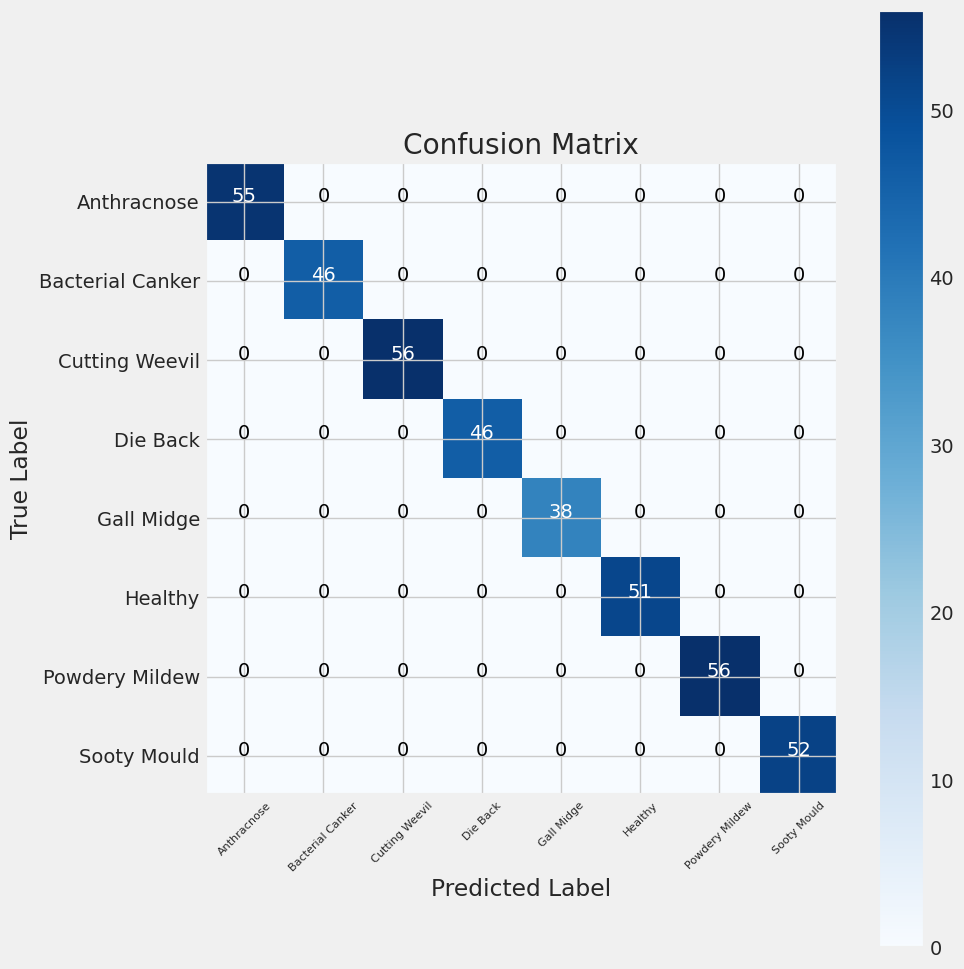

In [25]:
y_pred = get_pred(EfficientNetB3_model, test_gen)

plot_confusion_matrix(test_gen, y_pred)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Classification Report:
                   precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        55
Bacterial Canker       1.00      1.00      1.00        46
  Cutting Weevil       1.00      1.00      1.00        56
        Die Back       1.00      1.00      1.00        46
      Gall Midge       1.00      1.00      1.00        38
         Healthy       1.00      1.00      1.00        51
  Powdery Mildew       1.00      1.00      1.00        56
     Sooty Mould       1.00      1.00      1.00        52

        accuracy                           1.00       400
       macro avg       1.00      1.00      1.00       400
    weighted avg       1.00      1.00      1.00       400

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
MSE: 0.0000
RMSE: 0.0000


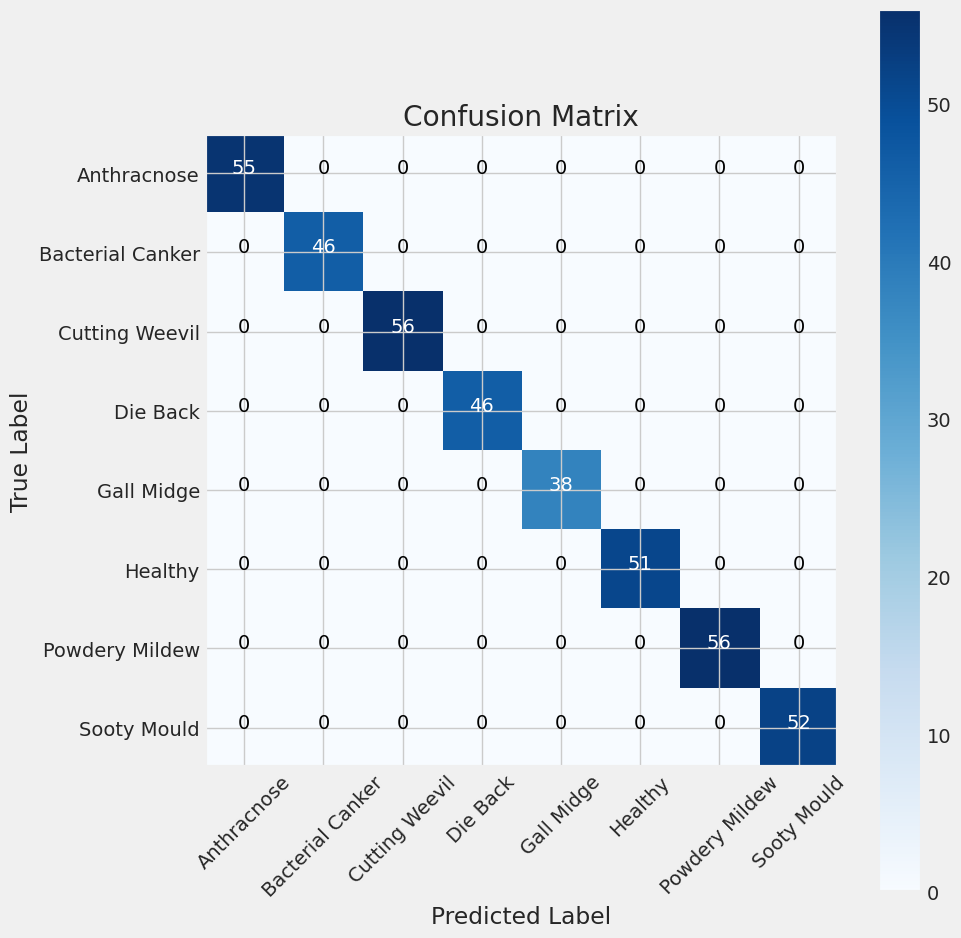

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error
import itertools

# Function to evaluate model and get metrics
def evaluate_model(model, test_gen):
    # Get true labels and predictions
    y_true = test_gen.classes
    y_pred = get_pred(model, test_gen)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute evaluation metrics
    report = classification_report(y_true, y_pred, target_names=classes)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print("Classification Report:\n", report)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate the model and print metrics
evaluate_model(EfficientNetB3_model, test_gen)

In [ ]:
# Save the full model in H5 format
EfficientNetB3_model.save('model_mango.h5')
print('Saved full model as model_mango.h5')

# Export model architecture to JSON
model_json = EfficientNetB3_model.to_json()
with open('model_mango.json', 'w') as json_file:
    json_file.write(model_json)
print('Saved model architecture as model_mango.json')

Saved full model as model_mango.h5
Saved model architecture as model_mango.json


In [ ]:
# Download the model files
from google.colab import files

# Download Keras model
files.download('model_mango.h5')

# Download JSON model
files.download('model_mango.json')
